# Task 1.2 Data Preparation
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to process the data

In [85]:
import math
import sys
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn import decomposition

We set pandas options


In [61]:
pd.set_option('mode.use_inf_as_na', True) #Set the inf values as pd.NA
pd.set_option('max_info_rows',12_000_000)


Then we load the cleaned dataset adn the users datset

In [62]:
df_cleaned = pd.read_csv('../dataset/cleaned_joined_tweets.csv', sep=',', index_col=0) # Load cleaned dataset
df_users = pd.read_csv('../dataset/cleaned_users.csv', sep=',', index_col=0)  # load users

In [63]:
df_users.rename(columns={'id':'user_id'}, inplace=True)

Then we cast the columns to the proper datatypes

In [64]:
df_cleaned.created_at = pd.to_datetime(df_cleaned.created_at)
df_cleaned.text = df_cleaned.text.astype('string')
df_cleaned.lang = pd.Categorical(df_cleaned.lang)

df_users.created_at = pd.to_datetime(df_users.created_at)
df_users.lang = pd.Categorical(df_users.lang)

In [65]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         11508 non-null  int64         
 1   lang            11508 non-null  category      
 2   bot             11508 non-null  int64         
 3   created_at      11508 non-null  datetime64[ns]
 4   statuses_count  11508 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(3)
memory usage: 461.5 KB


In [66]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11277758 entries, 0 to 11277757
Data columns (total 14 columns):
 #   Column           Non-Null Count     Dtype         
---  ------           --------------     -----         
 0   user_id          11277758 non-null  int64         
 1   id               10901728 non-null  float64       
 2   retweet_count    11277758 non-null  int64         
 3   reply_count      11277758 non-null  int64         
 4   favorite_count   11277758 non-null  int64         
 5   num_hashtags     11277758 non-null  int64         
 6   num_urls         11277758 non-null  int64         
 7   num_mentions     11277758 non-null  int64         
 8   created_at       11277758 non-null  datetime64[ns]
 9   text             10860709 non-null  string        
 10  lang             11277758 non-null  category      
 11  bot              11277758 non-null  bool          
 12  created_at_user  11277758 non-null  object        
 13  statuses_count   11277758 non-null  int6

## Plot graphics and correlation map

## Extracting indicators
Indicators per user covered: 

* total number of tweets    
* average tweet length, 
* total number of likes, 
* like ratio per tweet,
* counter of tweets outside of possible publishing years
* entropy peer user with second wise precision

### Functions used to extract indicators


Function to determine if the tweet is outside of possible publishing years.

It is delimited between the 2006, the creation year of twitter and 2020, the year of the data crawling

In [67]:
min_date = np.datetime64('2006-07-15 00:00:00') # Twitter creation year, used to check if a tweet is published after the creation of twitter
max_date = np.datetime64('2020-12-31 23:59:59') # Data scraping year, used to check if a tweet is published before the data scraping

def get_tweet_outside_of_possible_publishing_years(tweet):
    if tweet.created_at < min_date or tweet.created_at > max_date:  # if the tweet is outside of the publishable period of time
        return 1
    else:
        return 0

Function that returns the number of likes of a specific tweet

In [68]:
def get_number_of_likes(tweet):
    try:
        return np.int64(tweet['favorite_count'])
    except:
        return 0

Function that calculates average attribute value for user (es: average number of hashtags in a tweet)

In [69]:
def avg_attributes(df, df_indicators): 
    df_avg = df.groupby(by='user_id').mean()

    df_avg.rename(columns = lambda col : str(col)+'_avg', inplace=True)
    #df_avg.info()

    df_avg.reset_index(inplace=True)
    
    return df_indicators.merge(df_avg, on='user_id', how='left')


In [70]:
def sum_attributes(df, df_indicators):
    df_sum = df.groupby(by='user_id').sum()

    df_sum.rename(columns = lambda col : str(col)+'_sum', inplace=True)
    #df_sum.info()

    df_sum.reset_index(inplace=True)
    
    return df_indicators.merge(df_sum, on='user_id', how='left')


Function that returns 1 if the tweet has text inside it (if the lenght of it is > 0) and 0 otherwise

In [71]:
def tweet_with_text_count(tweet):
    tweet_len = len(str(tweet['text']))
    if tweet_len > 0:
        return 1
    else:
        return 0

Function that returns the average tweet lenght of the tweets of a user, is a moving average that is calculated if the tweet has text inside it.

In [72]:
def get_avg_tweet_len(indicators_dataframe, user_id ,tweet):
    tweet_len = len(str(tweet['text'])) # if tweet['text'] is np.nan, the len(str(np.nan)) is 0
    previous_avg = indicators_dataframe.at[user_id, 'avg_tweet_len']

    if np.isnan(previous_avg): #if the previous avg does not exist it means that the average has yet to be calculated
        return tweet_len #it returns 0 if the len is 0, so if the tweet has no text

    elif tweet_len > 0: #if the tweet has a text, use it to calculate the avg tweet len
        tweet_count = indicators_dataframe.at[user_id, 'tweet_with_text_count']
        
        # summing the previous average multiplied for n/n+1 with the current tweet length multiplied for
        # 1/n+1 gives us the current average where n is the previous tweet count
        avg_tweet_len = previous_avg * ((tweet_count - 1) / tweet_count) \
                        + tweet_len * (1 / tweet_count)

        return avg_tweet_len
    else: #otherwise return the previous avg
        return previous_avg



Function that set the indicators for eache using the functions above.

In [73]:
def set_indicators(indicators_dataframe, user_id, tweet):
    # if a user published a tweet and is not into the dataframe
    if user_id not in indicators_dataframe.index:
        # tweet count is set to 1 and the average length is the length of the sole tweet published
        #Assign to the indicator dataframe
        indicators_dataframe.at[user_id, 'tweet_count'] = 1
        indicators_dataframe.at[user_id, 'tweet_with_text_count'] = tweet_with_text_count(tweet)
        indicators_dataframe.at[user_id, 'total_num_of_likes'] = get_number_of_likes(tweet)
        indicators_dataframe.at[user_id, 'avg_tweet_len'] = get_avg_tweet_len(indicators_dataframe, user_id ,tweet)
        indicators_dataframe.at[user_id, 'tweet_outside_of_possible_publishing_years'] = get_tweet_outside_of_possible_publishing_years(tweet)

    # if a user published a tweet and is into the dataframe
    else:
        #Update to the indicator dataframe
        indicators_dataframe.at[user_id, 'tweet_count'] += 1
        indicators_dataframe.at[user_id, 'tweet_with_text_count'] += tweet_with_text_count(tweet)
        indicators_dataframe.at[user_id, 'total_num_of_likes'] += get_number_of_likes(tweet)
        indicators_dataframe.at[user_id, 'avg_tweet_len'] = get_avg_tweet_len(indicators_dataframe, user_id ,tweet)
        indicators_dataframe.at[user_id, 'tweet_outside_of_possible_publishing_years'] += get_tweet_outside_of_possible_publishing_years(tweet)

Function to get the ratios using the values of each user, in this case is performed only the like ratio received per tweet of each user.

In [74]:
def get_ratios(indicators_dataframe):
    for id_user, user in tqdm(indicators_dataframe.iterrows(),desc='Getting ratios',total=len(indicators_dataframe)):
        # tweet count is always >0, so there is no risk of a zero division
        user['like_ratio_per_tweet'] = user['total_num_of_likes'] / user['tweet_count']

#### Entropy extraction functions

get_entropy_dict_from_timedeltas is a function that give the dictionary 'dict_of_dict_of_timedeltas', it calculates the entropy of each user.

'dict_of_dict_of_timedeltas' is in the form of  n*{user_id : m*{timedelta_i : number of times timedelta_i has been encountered}} where there are n users and m category of timedelta.

In [75]:
#The threshold is needed to consider a meaningful number of tweets for applying the entropy
entropy_threshold = 10

def get_entropy_dict_from_timedeltas(dict_of_dict_of_timedeltas):
    entropy_dict = dict()
    for user_id in tqdm(dict_of_dict_of_timedeltas,desc='Getting user\'s entropy from timedeltas',total=len(dict_of_dict_of_timedeltas)):
        dict_of_timedeltas_of_the_user = dict_of_dict_of_timedeltas[user_id]
        total_number_of_timedeltas = sum(dict_of_timedeltas_of_the_user.values()) #the total number of timedeltas appeared
        if total_number_of_timedeltas >= entropy_threshold:
            entropy = 0. #entropy set to 0.
            for timedelta in dict_of_timedeltas_of_the_user:
                number_of_timedelta = dict_of_timedeltas_of_the_user[timedelta] #the number of times the unique timedelta has appeared
                #The probability of a timedelta to appear is the number of times the unique timedelta has appeared over total number of times timedeltas appeared
                entropy -= number_of_timedelta/total_number_of_timedeltas * np.log2(number_of_timedelta/total_number_of_timedeltas) #shannon's entropy

            entropy_dict[user_id] = entropy
        else:
            entropy_dict[user_id] = np.nan
    return entropy_dict

apply_time_precision convert the timedelta to the desired precision specified by 'time_precision'.

'time_precision' could be: 'seconds', 'minute', '15minutes', 'hour', 'day'.

In [76]:
def apply_time_precision(timedelta, time_precision='second'):
    if time_precision=='minute':
        return timedelta.round(freq='min') # approximate to nearest minute
    elif time_precision=='15minutes':
        return timedelta.round(freq='15min') # approximate to nearest 15 minutes
    elif time_precision=='hour':
        return timedelta.round(freq='h') # approximate to nearest hour
    elif time_precision=='day': 
        return timedelta.round(freq='D') # approximate to nearest day
    else:
        return timedelta.round(freq='s') # # approximate to nearest second (default)

get_timedelta_list_per_user generate the dictionary 'dict_of_dict_of_timedeltas' to get the entropies from.

In [77]:
def get_timedelta_list_per_user(time_precision='second'):
    df_cleaned.sort_values(by="created_at",inplace=True) # is needed to be sorted by date in order to be able to subtract the previous date from the current

    last_tweet_encountered = dict() #a dict where the key is user_id and the value is the last post datetime64. It is needed to get the timedelta between posts
    tweet_timedeltas = dict() #a dict where the key is user_id and the value is a dict containing the timedeltas:number_of_times_timedelta_encountered

    for _, tweet in tqdm(df_cleaned.iterrows(),desc='Getting timedeltas list with '+time_precision+' precision', total=len(df_cleaned)): #iterating on rows
        try: #if user_id cannot be casted into int64 it skips the tweet
            user_id = np.int64(tweet['user_id'])
        except:
            continue

        if user_id not in tweet_timedeltas.keys(): # if user is not into the timedeltas
            last_tweet_encountered[user_id] = tweet.created_at #the first datetime is saved
            tweet_timedeltas[user_id] = dict() #the dict containing timedelta:number_of_times_timedelta_encountered is created
        else:
            timedelta = tweet.created_at - last_tweet_encountered[user_id] #subrtacting the previous datetime64 to the current datetime64 gives the timedelta between the 2
            timedelta = apply_time_precision(timedelta, time_precision) #approximate the time to the nearest timedelta given the precision
            last_tweet_encountered[user_id] = tweet.created_at # the last datetime64 is saved
            if timedelta not in tweet_timedeltas[user_id]: # if the timedelta is not in the dict containing timedelta:number_of_times_timedelta_encountered
                tweet_timedeltas[user_id][timedelta] = 1 # it is the first timedelta, so it has appeared only 1 time
            else:
                tweet_timedeltas[user_id][timedelta] += 1 # it has already appeared, so the number of times encountered increases by 1
    
    return tweet_timedeltas

get_entropy_over_time returns the dataframe with the user_id and the associated entropy.

In [78]:
def get_entropy_over_time(time_precision='second'):
    #Subtract from each datetime the previous datetime, obtaining the timedeltas.
    #Calculate the entropy on those timedeltas (if the timedeltas are the same, the entropy will be lower)
    
    list_of_timedeltas = get_timedelta_list_per_user(time_precision)
    user_entropy_dict = get_entropy_dict_from_timedeltas(list_of_timedeltas) # a dict where the key is user_id and the value is the entropy of the user

    df_entropy = pd.DataFrame(columns=['user_id', 'entropy_'+time_precision])

    #saving the dict as a dataframe
    index = 0
    for user_id in tqdm(user_entropy_dict,desc='Converting dict to dataframe',total=len(user_entropy_dict)): 
        df_entropy.at[index, 'user_id'] = user_id
        df_entropy.at[index, 'entropy_'+time_precision] = user_entropy_dict[user_id]
        index += 1
    
    df_entropy['user_id'] = df_entropy['user_id'].astype('Int64')
    df_entropy['entropy_'+time_precision] = df_entropy['entropy_'+time_precision].astype('Float64')
    
    return df_entropy
    

get_indicators_csv returns the dataframe with the users' ids and all the indicators associated to them.

In [79]:
def avg_tweet_length(df, df_indicators):
    df_text_avg_len = df[['user_id', 'text_len']].groupby(by='user_id').mean()
    df_text_avg_len.reset_index(inplace=True)
    
    df_text_avg_len.rename(columns={'text_len':'avg_text_len'}, inplace=True)
    return df_indicators.merge(df_text_avg_len, on='user_id', how='left')


In [80]:
def count_tweets_with_text(df, df_indicators):    

    df_tweet_with_text_count = df[['user_id', 'text_len']].loc[df.text_len != 0].groupby(by='user_id').count()
    df_tweet_with_text_count.reset_index(inplace=True)
    df_tweet_with_text_count.rename(columns={'text_len':'tweet_with_text_count'}, inplace=True)

    df_indicators_joined = df_indicators.merge(df_tweet_with_text_count, on='user_id', how='left')
    df_indicators_joined.tweet_with_text_count.fillna(value=0, inplace=True)
    
    
    return df_indicators_joined


In [81]:
def extract_tweet_count(df):
    df_count = df[['user_id', 'text']].groupby(by='user_id').count()
    df_count.rename(columns={'text':'tweet_count'}, inplace=True)
    df_count.reset_index(inplace=True)
    
    return df_count

In [89]:
def bot_fill_na(df_indicators):
    df_indicators.fillna(df_indicators[df_indicators['bot'] == 1].median(), inplace=True)
    df_indicators.fillna(df_indicators[df_indicators['bot'] == 0].median(), inplace=True)


In [91]:
def calculate_entropies(): 
    df_entropies = get_entropy_over_time(time_precision='second')
    for time_precision in ['minute','15minutes','hour','day']:
        df_entropy = get_entropy_over_time(time_precision=time_precision)
        df_entropies = pd.merge(df_entropies, df_entropy, how='inner', left_on='user_id', right_on='user_id')
    
    df_entropies.to_csv('../dataset/entropies.csv')


In [92]:
calculate_entropies()

Getting timedeltas list with second precision:   0%|          | 0/11277758 [00:00<?, ?it/s]

Getting user's entropy from timedeltas:   0%|          | 0/11508 [00:00<?, ?it/s]

Converting dict to dataframe:   0%|          | 0/11508 [00:00<?, ?it/s]

Getting timedeltas list with minute precision:   0%|          | 0/11277758 [00:00<?, ?it/s]

Getting user's entropy from timedeltas:   0%|          | 0/11508 [00:00<?, ?it/s]

Converting dict to dataframe:   0%|          | 0/11508 [00:00<?, ?it/s]

Getting timedeltas list with 15minutes precision:   0%|          | 0/11277758 [00:00<?, ?it/s]

Getting user's entropy from timedeltas:   0%|          | 0/11508 [00:00<?, ?it/s]

Converting dict to dataframe:   0%|          | 0/11508 [00:00<?, ?it/s]

Getting timedeltas list with hour precision:   0%|          | 0/11277758 [00:00<?, ?it/s]

Getting user's entropy from timedeltas:   0%|          | 0/11508 [00:00<?, ?it/s]

Converting dict to dataframe:   0%|          | 0/11508 [00:00<?, ?it/s]

Getting timedeltas list with day precision:   0%|          | 0/11277758 [00:00<?, ?it/s]

Getting user's entropy from timedeltas:   0%|          | 0/11508 [00:00<?, ?it/s]

Converting dict to dataframe:   0%|          | 0/11508 [00:00<?, ?it/s]

In [115]:
def get_indicators_csv(df_cleaned):
    # create a dataframe for storing indicators
    #['tweet_count', 'tweet_with_text_count', 'avg_tweet_len', 'tweets_outside_of_possible_publishing_years'])
    # setting the index column name to 'id'
    df_indicators = extract_tweet_count(df_cleaned)
    print('Done extract_tweet_count')
    #print('AFTER TWEET COUNT')
    #df_indicators.info()

    df_cleaned['text_len'] = df_cleaned.text.apply(lambda text_str : len(str(text_str)))

    df_indicators = avg_tweet_length(df_cleaned[['user_id', 'text_len']].copy(), df_indicators)
    #print('AFTER AVG')
    #df_indicators.info()

    df_indicators = count_tweets_with_text(df_cleaned[['user_id', 'text_len']].copy(), df_indicators)

    print('Done extract_text_indicators')

    
    #Entropies start merging 
    
    df_entropies = pd.read_csv('../dataset/entropies.csv')

    df_indicators = pd.merge(df_indicators, df_users, how='inner', left_on='user_id', right_on='user_id')

    for col_name in ["created_at", "lang", "statuses_count"]: #dropping columns that are not useful to calculate the median
        del df_indicators[col_name]

    df_indicators = pd.merge(df_indicators, df_entropies, how='inner', left_on='user_id', right_on='user_id')

    bot_fill_na(df_indicators) #filling nan entropies with the median with respect to the fact the user is bot or not

    del df_indicators ['bot']
    del df_indicators ['Unnamed: 0'] #scrap rom the merge

    #Entropies end merging

    for col_name in ["id", "created_at", "text", "lang", "bot", "created_at_user", "statuses_count", "text_len"]:
        del df_cleaned[col_name]

    df_indicators = avg_attributes(df_cleaned, df_indicators)
    print('Done avg_attributes')

    df_indicators = sum_attributes(df_cleaned, df_indicators)
    print('Done sum_attributes')

    
    df_indicators.to_csv('../dataset/indicators.csv')

    return df_indicators

In [116]:
indicators = get_indicators_csv(df_cleaned.copy())

Done extract_tweet_count
Done extract_text_indicators
Done avg_attributes
Done sum_attributes


## 
The reason behind the </> in the output is due to the fact that tqdm was used to get progress bars that can't be seen once the ipynb is reopened.

In [117]:
indicators.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                11508 non-null  int64  
 1   tweet_count            11508 non-null  int64  
 2   avg_text_len           11508 non-null  float64
 3   tweet_with_text_count  11508 non-null  int64  
 4   entropy_second         11508 non-null  float64
 5   entropy_minute         11508 non-null  float64
 6   entropy_15minutes      11508 non-null  float64
 7   entropy_hour           11508 non-null  float64
 8   entropy_day            11508 non-null  float64
 9   retweet_count_avg      11508 non-null  float64
 10  reply_count_avg        11508 non-null  float64
 11  favorite_count_avg     11508 non-null  float64
 12  num_hashtags_avg       11508 non-null  float64
 13  num_urls_avg           11508 non-null  float64
 14  num_mentions_avg       11508 non-null  float64
 15  re

Merging the user dataframe to the user indicator dataframe, converting the dtypes and setting the user_id as the index.

Then the final dataframe is saved as a csv because we will load them since we don't want to perform the computation every time since it takes around 4 hours.

In [56]:
#Merge indicators on user dataframe
df_users_indicators = df_users.merge(indicators,on='user_id', how='left')
df_users_indicators.drop(columns='tweet_with_text_count',inplace=True)
df_users_indicators = df_users_indicators.convert_dtypes()

user_id                                       1.174713e+09
bot                                           1.000000e+00
statuses_count                                5.300000e+01
Unnamed: 0                                    6.915000e+03
tweet_count                                   1.140000e+02
tweet_with_text_count                         1.140000e+02
avg_tweet_len                                 6.615891e+01
total_num_of_likes                            6.000000e+00
like_ratio_per_tweet                          4.285714e-02
tweet_outside_of_possible_publishing_years    0.000000e+00
entropy_day                                   1.265081e+00
entropy_second                                5.407369e+00
entropy_minute                                4.000000e+00
entropy_15minutes                             2.846439e+00
entropy_hour                                  2.049230e+00
dtype: float64


c:\Users\Kaos1\anaconda3\envs\dataMiningEnv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  
c:\Users\Kaos1\anaconda3\envs\dataMiningEnv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
c:\Users\Kaos1\anaconda3\envs\dataMiningEnv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\Kaos1\anaconda3\envs\dataMiningEnv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reduc

,user_id,lang,bot,created_at,statuses_count,Unnamed: 0,tweet_count,tweet_with_text_count,avg_tweet_len,total_num_of_likes,like_ratio_per_tweet,tweet_outside_of_possible_publishing_years,entropy_day,entropy_second,entropy_minute,entropy_15minutes,entropy_hour
11488,2353571924,en,1,2019-02-22 17:42:24,70,5399,156,156,63.032051,15,0.096154,0,1.200779,5.509171,2.367442,1.836238,1.797528
11489,532556025,en,0,2017-03-23 18:54:59,27689,1389,2494,2494,93.253809,329,0.131917,0,0.336131,9.465757,6.476635,3.650578,2.445202
11490,838827888,en,0,2017-09-24 01:01:04,25541,336,3579,3579,45.065940,1521,0.424979,0,0.058074,9.210478,5.262330,2.361560,1.294561
11491,797250055,en,0,2017-09-04 01:29:15,12659,319,2005,2005,41.035411,418,0.208479,0,0.325139,8.739245,5.281848,2.766964,1.789593
11492,2356252633,en,1,2019-02-24 11:56:57,72,9351,151,151,69.470199,3,0.019868,0,1.143154,5.556086,2.280849,1.620936,1.594269
11493,2275248397,it,1,2019-01-05 23:30:10,488,554,2017,2017,84.437283,844,0.418443,0,0.448801,9.735042,7.822233,4.859366,3.266325
11494,176688197,es,0,2015-08-12 04:55:53,8896,4076,2602,2602,81.229823,361,0.138739,0,0.730845,9.933883,7.835456,4.912119,3.348161
11495,1176247080,en,1,2018-02-15 17:31:37,19,10473,21,21,58.857143,0,0.000000,0,2.903702,4.221928,4.221928,4.121928,4.021928
11496,39220893,en,0,2014-05-13 09:14:56,11688,5192,1765,1765,75.931445,638,0.361473,0,0.685936,9.494167,7.273464,4.448719,3.079750
11497,2364069194,en,1,2019-03-01 11:59:58,50,4656,120,120,62.608333,9,0.075000,0,1.280932,5.397558,2.237159,1.717243,1.717243


Loading the indicators, because we don't want to perform the computation every time since it takes around 4 hours.

In [ ]:
df_users_indicators = df_users_indicators.convert_dtypes()
df_users_indicators.lang = pd.Categorical(df_users_indicators.lang)
df_users_indicators.created_at = pd.to_datetime(df_users_indicators.created_at, errors='coerce')
df_users_indicators.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 2353593986 to 933183398
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   name                                        11507 non-null  string        
 1   lang                                        11508 non-null  category      
 2   bot                                         11508 non-null  Int64         
 3   created_at                                  11508 non-null  datetime64[ns]
 4   statuses_count                              11109 non-null  Int64         
 5   tweet_count                                 11508 non-null  Int64         
 6   avg_tweet_len                               11508 non-null  Float64       
 7   total_num_of_likes                          11508 non-null  Int64         
 8   like_ratio_per_tweet                        11508 non-null  Float64      

## Correlation map on indicators

Now we visualize the correlation matrix to highlist the correlation between the attributes

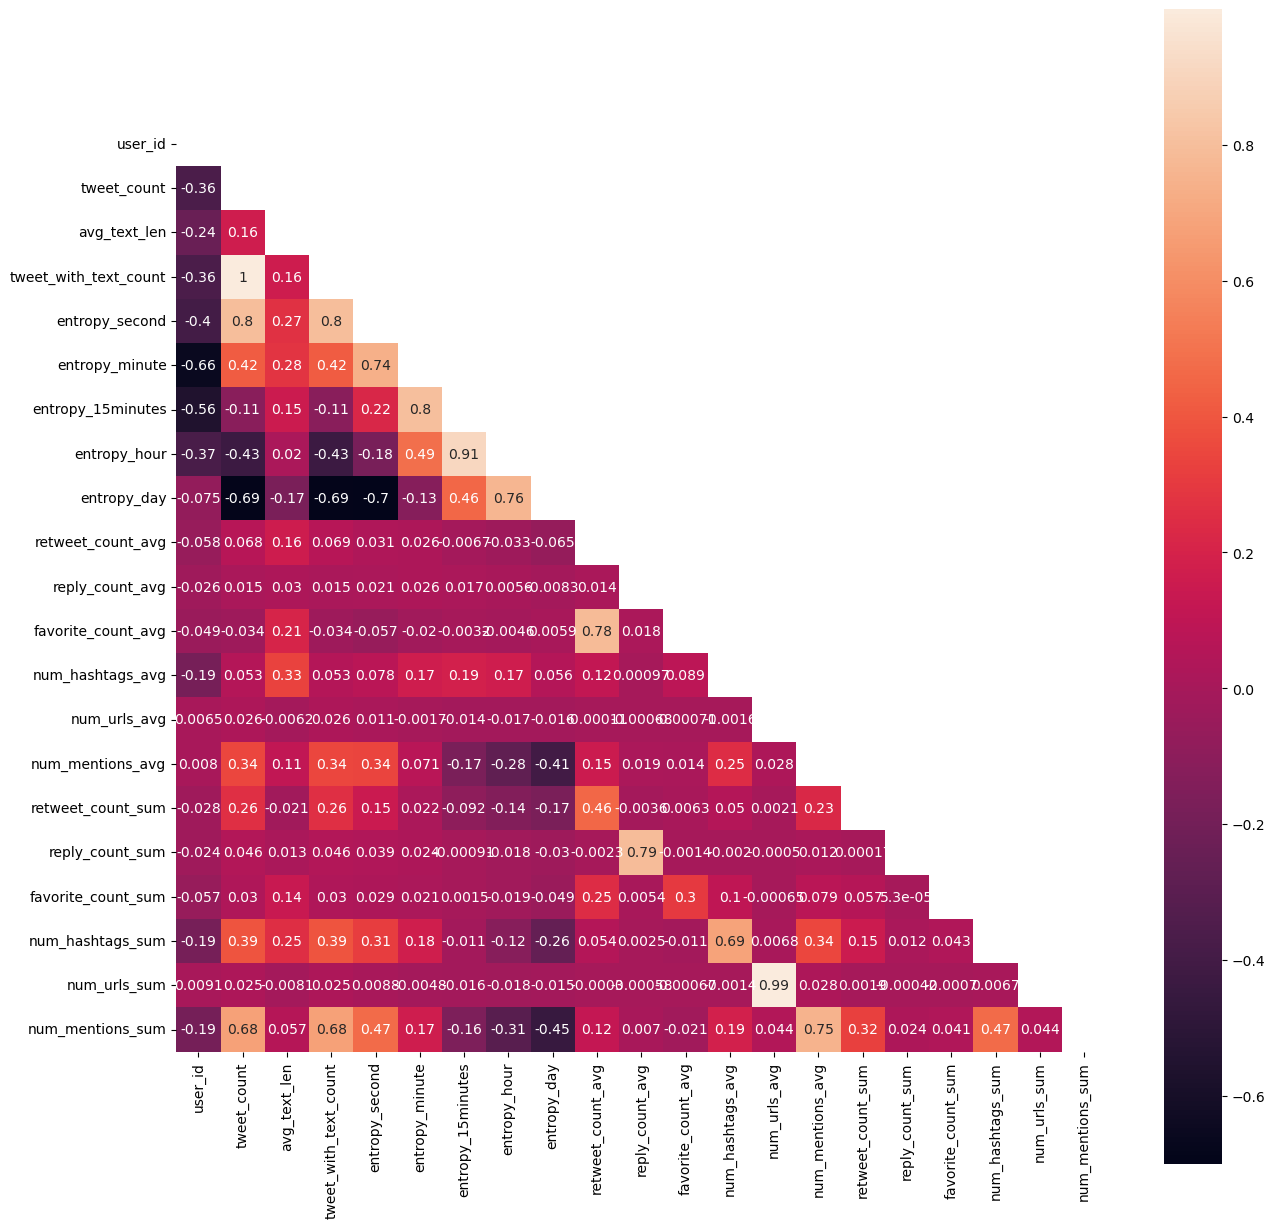

In [118]:
corr_matrix = indicators.corr()

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
sn.heatmap(corr_matrix, annot=True, mask=mask, square=True)

plt.show()

We discard the following features due to high correlation:
TODO DA SISTEMARE
* Entropy 15 minutes
* Tweet count
* Tweet outside of possible publishing year
* Total number of likes
* Like ratio per tweet 
* Avg tweet len

## Remove useless features

In [77]:
del df_users_indicators['tweet_with_text_count']
del df_users_indicators['reply_count_sum']
del df_users_indicators['num_hashtags_sum']
del df_users_indicators['num_urls_sum']
del df_users_indicators['num_mentions_sum']
del df_users_indicators['entropy_15minutes']
del df_users_indicators['entropy_second']

In [78]:
df_users_indicators.set_index('user_id',inplace=True)
df_users_indicators.to_csv('../dataset/user_indicators.csv')

In [79]:
df_users_indicators = pd.read_csv('../dataset/user_indicators.csv', sep=',', index_col=0)
df_users_indicators.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 2353593986 to 933183398
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lang                11508 non-null  object 
 1   bot                 11508 non-null  bool   
 2   created_at          11508 non-null  object 
 3   statuses_count      11508 non-null  int64  
 4   tweet_count         11508 non-null  int64  
 5   avg_text_len        11508 non-null  float64
 6   retweet_count_avg   11508 non-null  float64
 7   reply_count_avg     11508 non-null  float64
 8   favorite_count_avg  11508 non-null  float64
 9   num_hashtags_avg    11508 non-null  float64
 10  num_urls_avg        11508 non-null  float64
 11  num_mentions_avg    11508 non-null  float64
 12  retweet_count_sum   11508 non-null  int64  
 13  favorite_count_sum  11508 non-null  int64  
dtypes: bool(1), float64(7), int64(4), object(2)
memory usage: 1.2+ MB
